In [4]:
import gym
from gym import spaces
import numpy as np
import pandas as pd
import scipy
from scipy.integrate import odeint
import csv

In [5]:
Ad      = 4.4e16
Ed      = 140.06e3
Ap      = 1.7e11/60
Ep      = 16.9e3/0.239
deltaHp = -82.2e3
UA      = 33.3083 #%18.8445;
Qc      = 650
Qs      = 12.41e-2
V       = 0.5
Tc      = 27
Tamb    = 27
Cpc     = 4.184
R       = 8.3145
alpha   = 1.212827
beta    = 0.000267
epsilon = 0.5
theta   = 1.25
m1      = 450
cp1     = 4.184
mjCpj   = (18*4.184)+(240*0.49)
cp2     = 187
cp3     = 110.58 #%J/molK
cp4     = 84.95
m5      = 220
cp5     = 0.49
m6      = 7900
cp6     = 0.49
M0      = 0.7034
I0      = 4.5e-3

# Define Batch Reactor model
def br(x,t,u,Ad):
    # Inputs:
    # Coolant flow rate
    F = u*16.667

    # States (4):
    # Initiator
    Ii  = x[0]
    # Monomer
    M  = x[1]
    # Reactor temperature
    Tr = x[2]
    # Jacket temperature
    Tj = x[3]

    Ri    = Ad*Ii*(np.exp(-Ed/(R*(Tr+273.15))))
    Rp    = Ap*(Ii**epsilon)*(M**(theta)*(np.exp(-Ep/(R*(Tr+273.15)))))
    mrCpr = m1*cp1+ Ii*cp2*V + M*cp3*V +(M0-M)*cp4*V+ m5*cp5 + m6*cp6
    Qpr   = alpha*(Tr-Tc)**beta

    # Computing the rate of change of I, M, Tr, Tj using Differential Equations
    dy1_dt = -Ri
    dy2_dt = -Rp
    dy3_dt = (Rp*V*(-deltaHp)-UA*(Tr-Tj)+Qc+Qs-Qpr)/mrCpr
    dy4_dt = (UA*(Tr-Tj)-F*Cpc*(Tj-Tc))/mjCpj

    # Return xdot:
    xdot = np.zeros(4)
    xdot[0] = dy1_dt
    xdot[1] = dy2_dt
    xdot[2] = dy3_dt
    xdot[3] = dy4_dt

    return xdot



In [6]:
class BR3 (gym.Env):

    def __init__(self):

        self.action_space = spaces.Box(low=0.25, high=0.75, shape=(1,), dtype=np.float32)

        self.observation_space = spaces.Box(low=0, high=100, shape=(2,), dtype=np.float32)

        self.t = np.linspace(0,7200,7201)
        self.i= 0

        Tr_ref = pd.read_csv('C:/Users/Nagbhushan_Pai/Desktop/DeskTOP/Arasu work/Trajectory2.csv') # Enter the CSV file directory for setpoints
        self.a1 = Tr_ref.values.tolist()
        self.sp = self.a1[self.i][0] # Saving the setpoints in an array

       # Assign Initial conditions to the variables
        self.I = 4.5e-3     # Initiator
        self.M = 0.7034     # Monomer
        self.Tr = 45.0      # Reactor Temperature
        self.Tj = 40.0      # Jacket Temperature

        self.state = self.Tr ,self.sp

        # Creating an NumPy array to store the values of I, M, Tr and Tj for give it as an argument to the br_equation function

        self.y0= np.empty(4)
        self.y0[0] = self.I        # Initiator Concentration
        self.y0[1] = self.M        # Monomer Concentration
        self.y0[2] = self.Tr       # Reactor Temperature
        self.y0[3] = self.Tj       # Jacket Temperature


        self.time_step= 7200 # Number of computation steps

    # Step function to give the coolant flow rate (in LPM) to the model, returning the next state and computed reward
    def step(self, action): # Note that the action is an array

        action = action[0]
        u = action

        ts = [self.t[self.i],self.t[self.i+1]]

        y = scipy.integrate.odeint(br,self.y0, ts , args=(u,4.4e16),)

        x = np.round(y, decimals=4)

        self.I = x[-1][0]
        self.M = x[-1][1]
        self.Tr = x[-1][2]
        self.Tj = x[-1][3]

        self.y0= np.empty(4)
        self.y0[0] = self.I        # Initiator Concentration
        self.y0[1] = self.M        # Monomer Concentration
        self.y0[2] = self.Tr       # Reactor Temperature
        self.y0[3] = self.Tj       # Jacket Temperature


        # Data saving snippet when using the model - Saves the data to a csv file
        data = [self.sp, self.Tr, self.Tj, action]
        with open('data.csv', 'a') as file:
            writer = csv.writer(file)
            writer.writerow(data)

        self.sp=self.a1[self.i][0]
        self.i += 1

        # Calculate the difference between Setpoint and Reactor Temperature (Process Variable)
        difference = self.sp - self.Tr
        self.reward = 0

        # Calculate the modulus of the difference
        error = abs(difference)

        # These rewards can be modified in accordance with the requirements
        if error <= 0.5:
            self.reward = +100
        elif error <= 1:
            self.reward = +50
        elif error <= 3:
            self.reward = +25
        elif error <= 4:
            self.reward = +10
        else:
            self.reward = -100

        if self.i>= self.time_step:
            done = True
        else:
            done = False

        info = {}

        self.state = self.Tr , self.sp

        return self.state, self.reward ,done ,info

    def reset(self):
        self.I  = 4.5e-3
        self.M  = 0.7034
        self.Tr = 45.0
        self.Tj = 40.0
        self.i  = 0

        self.sp = self.a1[self.i][0]
        self.state=self.Tr,self.sp

        self.y0= np.empty(4)
        self.y0[0] = self.I        # Initiator Concentration
        self.y0[1] = self.M        # Monomer Concentration
        self.y0[2] = self.Tr       # Reactor Temperature
        self.y0[3] = self.Tj       # Jacket Temperature

        return self.state

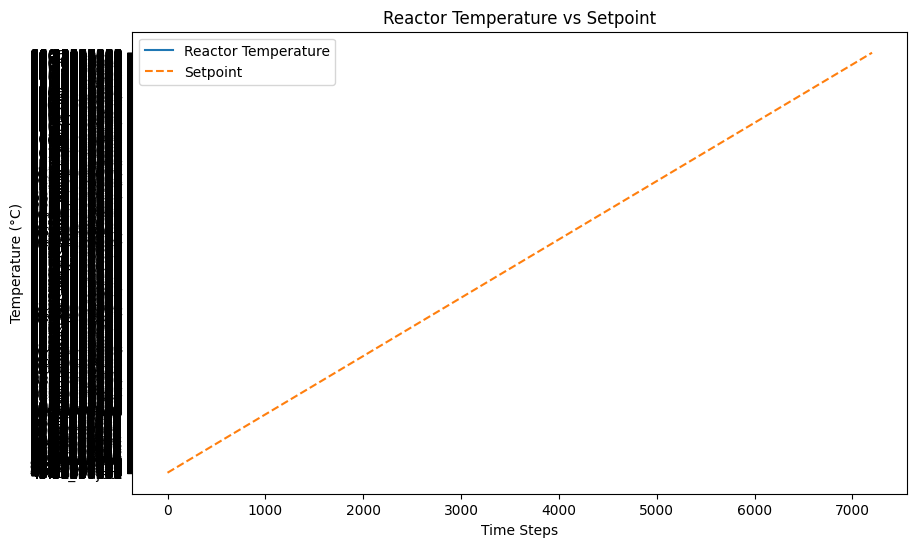

In [7]:
import matplotlib.pyplot as plt
import pandas as pd
# Read the data from the CSV file
data = pd.read_csv(r'C:\Users\Nagbhushan_Pai\Desktop\DeskTOP\Arasu work\batch_reactor\Trajectory2.csv', header=None, names=['Setpoint', 'Reactor Temperature', 'Jacket Temperature', 'Action'])

# Plot the data
plt.figure(figsize=(10, 6))

# Plot Reactor Temperature and Setpoint
plt.plot(data['Reactor Temperature'], label='Reactor Temperature')
plt.plot(data['Setpoint'], label='Setpoint', linestyle='--')

# Add labels and legend
plt.xlabel('Time Steps')
plt.ylabel('Temperature (°C)')
plt.title('Reactor Temperature vs Setpoint')
plt.legend()

# Show the plot
plt.show()

In [ ]:
env = BR3()
state = env.reset()
print(state)  # Should print initial (Tr, setpoint)
action = [0.5]  # Sample action
next_state, reward, done, info = env.step(action)
print(next_state, reward, done, info)

FileNotFoundError: [Errno 2] No such file or directory: 'C:/Users/Nagbhushan_Pai/Desktop/DeskTOP/Arasu work/Trajectory2.csv'

In [10]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
from copy import deepcopy
import matplotlib.pyplot as plt
from tqdm import tqdm
import os
from scipy.integrate import solve_ivp

# Ensure output directory exists
output_dir = "training_plots"
os.makedirs(output_dir, exist_ok=True)

# Load Trajectory Data
csv_path = "Trajectory2.csv"
if os.path.exists(csv_path):
    df = pd.read_csv(csv_path)
else:
    print("Warning: Trajectory2.csv not found! Using dummy data.")
    df = pd.DataFrame({"Time": np.arange(0, 1000, 1), "Setpoint": np.random.uniform(0.25, 0.75, 1000)})

# Actor Network
class Actor(nn.Module):
    def __init__(self):
        super(Actor, self).__init__()
        self.fc1 = nn.Linear(2, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 1)
        self.relu = nn.ReLU()
        self.tanh = nn.Tanh()

    def forward(self, s):
        x = self.relu(self.fc1(s))
        x = self.relu(self.fc2(x))
        x = self.tanh(self.fc3(x)) * 0.25 + 0.5
        return x

# Critic Network
class Critic(nn.Module):
    def __init__(self):
        super(Critic, self).__init__()
        self.fc1 = nn.Linear(3, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 1)
        self.relu = nn.ReLU()

    def forward(self, s, a):
        x = torch.cat([s, a], dim=-1)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Initialize Networks
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
P = 2
actors = [Actor().to(device) for _ in range(P)]
critics = [Critic().to(device) for _ in range(P)]
target_actors = [deepcopy(a).to(device) for a in actors]
target_critics = [deepcopy(c).to(device) for c in critics]
replay_buffers = [[] for _ in range(P)]
optimizers_actor = [torch.optim.Adam(a.parameters(), lr=0.001) for a in actors]
optimizers_critic = [torch.optim.Adam(c.parameters(), lr=0.001) for c in critics]

# Training parameters
L = 2  # Episodes
T = 7200  # Timesteps
gamma = 0.98
Np = [64, 64]
M = 10

# Data Storage (Avoids Writing Per Step)
final_data = []

# Training Loop
for episode in tqdm(range(L), desc="Training Episodes"):
    state = [0.5, 0.5]  # Reset environment state
    episode_data = []
    v = np.random.normal(0, 0.1)

    for t in range(T):
        phase = 0 if t < 4000 else 1
        s_tensor = torch.FloatTensor(state).unsqueeze(0).to(device)
        a_tensor = actors[phase](s_tensor)
        action = a_tensor.detach().cpu().numpy()[0] + v
        action = np.clip(action, 0.25, 0.75)
        next_state = [np.clip(state[0] + np.random.normal(0, 0.01), 0.2, 0.8), df.iloc[min(t, len(df)-1)]["Setpoint"]]
        reward = -abs(next_state[0] - next_state[1])
        done = False

        episode_data.append((state, action, reward, next_state, phase))
        state = next_state

    # Compute Returns
    G = []
    discounted_reward = 0
    for _, _, r, _, _ in reversed(episode_data):
        discounted_reward = r + gamma * discounted_reward
        G.insert(0, discounted_reward)

    # Store in Replay Buffer
    for i, (s, a, _, _, p) in enumerate(episode_data):
        replay_buffers[p].append((s, a, G[i]))
        if len(replay_buffers[p]) > 5000:
            replay_buffers[p].pop(0)

    # Train Networks
    for p in range(P):
        if len(replay_buffers[p]) >= Np[p]:
            for _ in range(M):
                indices = np.random.choice(len(replay_buffers[p]), Np[p], replace=False)
                batch = [replay_buffers[p][i] for i in indices]
                s_batch = torch.FloatTensor([b[0] for b in batch]).to(device)
                a_batch = torch.FloatTensor([b[1] for b in batch]).unsqueeze(-1).to(device)
                g_batch = torch.FloatTensor([b[2] for b in batch]).unsqueeze(-1).to(device)

                optimizers_critic[p].zero_grad()
                q_pred = critics[p](s_batch, a_batch)
                critic_loss = nn.MSELoss()(q_pred, g_batch)
                critic_loss.backward()
                optimizers_critic[p].step()

                optimizers_actor[p].zero_grad()
                a_pred = actors[p](s_batch)
                q_val = critics[p](s_batch, a_pred)
                actor_loss = -q_val.mean()
                actor_loss.backward()
                optimizers_actor[p].step()

    # Save Episode Data for Final CSV
    final_data.extend([(t, d[0][0], d[0][1], d[1], d[2]) for t, d in enumerate(episode_data)])

    # Save Episode Plot
    if episode % 50 == 0:
        times = np.arange(len(episode_data))
        tr = [s[0] for s, _, _, _, _ in episode_data]
        sp = [s[1] for s, _, _, _, _ in episode_data]
        actions = [a for _, a, _, _, _ in episode_data]

        plt.figure(figsize=(10, 8))
        plt.subplot(2, 1, 1)
        plt.plot(times, tr, label="Tr")
        plt.plot(times, sp, label="Setpoint")
        plt.xlabel("Time")
        plt.ylabel("Temperature")
        plt.legend()
        plt.title(f"Episode {episode}")

        plt.subplot(2, 1, 2)
        plt.plot(times, actions, label="Coolant Flow Rate")
        plt.xlabel("Time")
        plt.ylabel("Flow Rate")
        plt.legend()

        plt.savefig(os.path.join(output_dir, f"episode_{episode}.png"))
        plt.close()

# Save Final Data to CSV
final_df = pd.DataFrame(final_data, columns=["Time", "Tr", "Setpoint", "Action", "Reward"])
final_df.to_csv("data.csv", index=False)
print("Final data.csv saved!")


Training Episodes:   0%|          | 0/2 [00:00<?, ?it/s]


KeyError: 'Setpoint'